In [ ]:
## Use this cell if notebook not in the directory of dataset.
import os
os.chdir('/content/drive/MyDrive/COVID-19_Radiography_Dataset')

# Covid 19 Chest X-Ray Analysis with GradCam

In this Notebook I use a pretrained `densenet121` for analysing Covid-19 Xrays and Visualise them using GradCam algorithm.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image,ImageOps
import torchvision
from torch import optim,nn
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from util import *

## Read  and  Process  Data

In [ ]:
## Define transfoms
standard_normalization = transforms.Normalize((0.5), (0.5))
data_transforms = transforms.Compose([transforms.RandomResizedCrop(256),
                                      transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     standard_normalization])
data_transforms_1 = transforms.Compose([transforms.RandomResizedCrop(256),
                                     transforms.ToTensor(),
                                     standard_normalization])

In [ ]:
# Read Data
dict_ = {0:"Covid",1:"Lung_Opacity",2:"Normal",3:"Viral Pheumonia"}

df = pd.read_csv("data.csv")
df = pd.concat([df,pd.get_dummies(df.tag)], axis=1)
df['tag_alp'] = df.tag.apply(lambda x : dict_[x-1])


<AxesSubplot:>

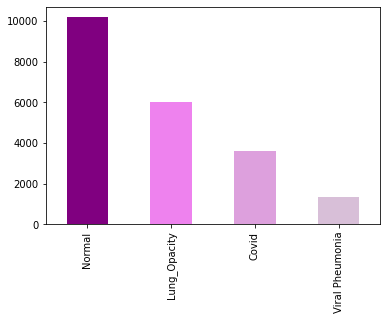

In [ ]:
### Visualise dataset
c = ['purple','violet','plum','thistle']
df['tag_alp'].value_counts().plot(kind = 'bar',color = c)

In [ ]:
#make train, test and val set

train, test = train_test_split(df,test_size=.2)
train_, val = train_test_split(train,test_size=.2)

In [ ]:
#reseting index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train_ = train_.reset_index(drop=True)
val = val.reset_index(drop=True)

In [ ]:
print(f"No of Images in Train Set : {train_.shape[0]}")
print(f"No of Images in Test Set : {test.shape[0]}")
print(f"No of Images in Validation Set : {val.shape[0]}")

No of Images in Train Set : 13545
No of Images in Test Set : 4233
No of Images in Validation Set : 3387


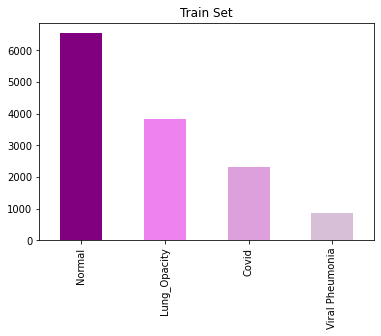

In [ ]:
train_['tag_alp'].value_counts().plot(kind = 'bar',color = c, title = "Train Set");

<AxesSubplot:title={'center':'Test Set'}>

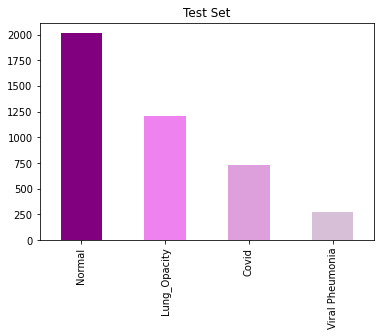

In [ ]:
test['tag_alp'].value_counts().plot(kind = 'bar',color = c, title = "Test Set")

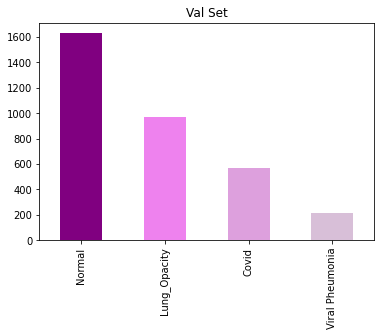

In [ ]:
val['tag_alp'].value_counts().plot(kind = 'bar',color = c, title = "Val Set");

In [ ]:
### Defining Random Sampler for Data Loader
from torch.utils.data import  WeightedRandomSampler
class_freq = torch.tensor(train_.tag.values).bincount()
weight = 1 / class_freq
samples_weight = weight[train_.tag.values]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

In [ ]:
root_dir = ""

trainset = Xray_dataset(train,root_dir,transform = data_transforms)
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = Xray_dataset(test,root_dir,transform = data_transforms_1)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)

trainset_ = Xray_dataset(train_,root_dir,transform = data_transforms)
train_loader_ = DataLoader(trainset_, batch_size=32, sampler=sampler)

valset = Xray_dataset(val,root_dir,transform = data_transforms)
val_loader = DataLoader(valset, batch_size=32, shuffle=True)

use_cuda = torch.cuda.is_available()
num_classes = 4

loaders = {"train": train_loader_,
           "test": test_loader,
           "val": val_loader}

## Download and Prepare Neural Network

In [ ]:
model = torchvision.models.resnet18(pretrained = True, progress = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
### Edit last classifier layer
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
if use_cuda:
    model = model.cuda()

In [ ]:
## Define Loss and optim
optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

## Train Model
### For saving time skip this cell and load pretrained model in next cell.

In [ ]:
## Train
train_model(20, loaders, model, optimizer, criterion, use_cuda, 'model_transfer.pt');

## Load the Saved Weights

In [ ]:
model = torch.load("model.pt")

## Test Model

In [ ]:
test_model(loaders,model,criterion,use_cuda)
conf_met(model,test_loader)

  0%|          | 0/133 [00:00<?, ?it/s]

Test Loss: 0.167763


Test Accuracy: 93% (3969/4233)


100%|██████████| 133/133 [00:26<00:00,  5.08it/s]


Confusion Metrix : 
[[ 704   12   17    0]
 [  10 1093  104    2]
 [  16   73 1900   26]
 [   0    0    3  273]]


## Draw GradCam Output

Grad-CAM: Gradient-weighted Class Activation Mapping

In [ ]:
class_met(model,test_loader)

100%|██████████| 133/133 [00:26<00:00,  5.11it/s]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       733
           1       0.93      0.92      0.92      1209
           2       0.95      0.95      0.95      2015
           3       0.93      0.98      0.96       276

    accuracy                           0.94      4233
   macro avg       0.94      0.95      0.95      4233
weighted avg       0.94      0.94      0.94      4233



Covid


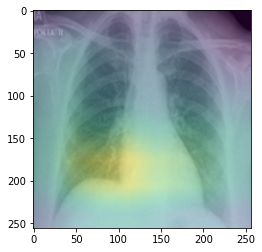

In [ ]:
img  = testset[170][0].unsqueeze(0).cuda()
target = testset[170][1]
print(dict_[int(target.numpy())])
grad_cam_resnet(model,img,model.layer4[-1])

Lung_Opacity


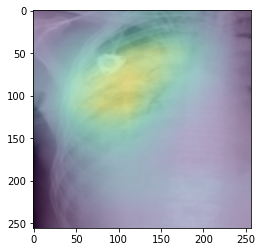

In [ ]:
img  = testset[15][0].unsqueeze(0).cuda()
target = testset[15][1]
print(dict_[int(target.numpy())])
grad_cam_resnet(model,img,model.layer4[-1])

Normal


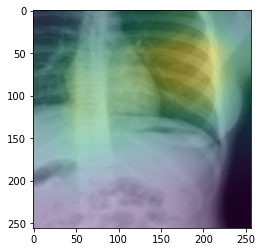

In [ ]:
img  = testset[5][0].unsqueeze(0).cuda()
target = testset[5][1]
print(dict_[int(target.numpy())])
grad_cam_resnet(model,img,model.layer4[-1])

Viral Pheumonia


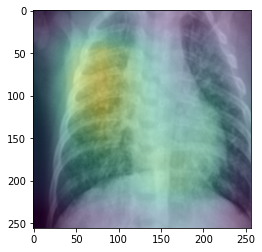

In [ ]:
img  = testset[10][0].unsqueeze(0).cuda()
target = testset[10][1]
print(dict_[int(target.numpy())])
grad_cam_resnet(model,img,model.layer4[-1])